# Binning low-level features so it can be used as a regressor

Rekha Varrier, 2022



- Binning optic flow and brightness data (original resolution: 33ms) to match the TR (0.72s or 720ms)

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [9]:
# setting default fontsizes for plots

s=16 # CHANGE FONTSIZE HERE

plt.rc('font', size=s) #controls default text size
plt.rc('axes', titlesize=s) #fontsize of the title
plt.rc('axes', labelsize=s) #fontsize of the x and y labels
plt.rc('xtick', labelsize=s) #fontsize of the x tick labels
plt.rc('ytick', labelsize=s) #fontsize of the y tick labels
plt.rc('legend', fontsize=s) #fontsize of the legend
plt.rcParams['savefig.facecolor']='white'
#import matplotlib as mpl
#mpl.rcParams['font.weight']= 'normal'


In [10]:
TR=.72
tr0_ind = 3 # onset TRs in the timecourse analyses plots (i.e., 3 indices before this set to NaN)

In [11]:
vidnames = ['COAXING-B', 'BILLIARD-A', 'DRIFTING-A', 'Fishing', 'RandomMechanical', 'Scaring','SEDUCING-B','STAR-A','SURPRISING-B','TENNIS-A']
stim_label = np.array([1,0,0,1,0,1,1,0,1,0])
# vid names as saved in behavioral data

In [12]:
# verifying the time bins
low_high_time_bounds = np.empty((28,2))
low_high_time_bounds[:] = np.nan
for t in range(28):
    low_high_time_bounds[t,:] = [(t*TR),(t+1)*TR]
low_high_time_bounds    

array([[ 0.  ,  0.72],
       [ 0.72,  1.44],
       [ 1.44,  2.16],
       [ 2.16,  2.88],
       [ 2.88,  3.6 ],
       [ 3.6 ,  4.32],
       [ 4.32,  5.04],
       [ 5.04,  5.76],
       [ 5.76,  6.48],
       [ 6.48,  7.2 ],
       [ 7.2 ,  7.92],
       [ 7.92,  8.64],
       [ 8.64,  9.36],
       [ 9.36, 10.08],
       [10.08, 10.8 ],
       [10.8 , 11.52],
       [11.52, 12.24],
       [12.24, 12.96],
       [12.96, 13.68],
       [13.68, 14.4 ],
       [14.4 , 15.12],
       [15.12, 15.84],
       [15.84, 16.56],
       [16.56, 17.28],
       [17.28, 18.  ],
       [18.  , 18.72],
       [18.72, 19.44],
       [19.44, 20.16]])

/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice
/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrm

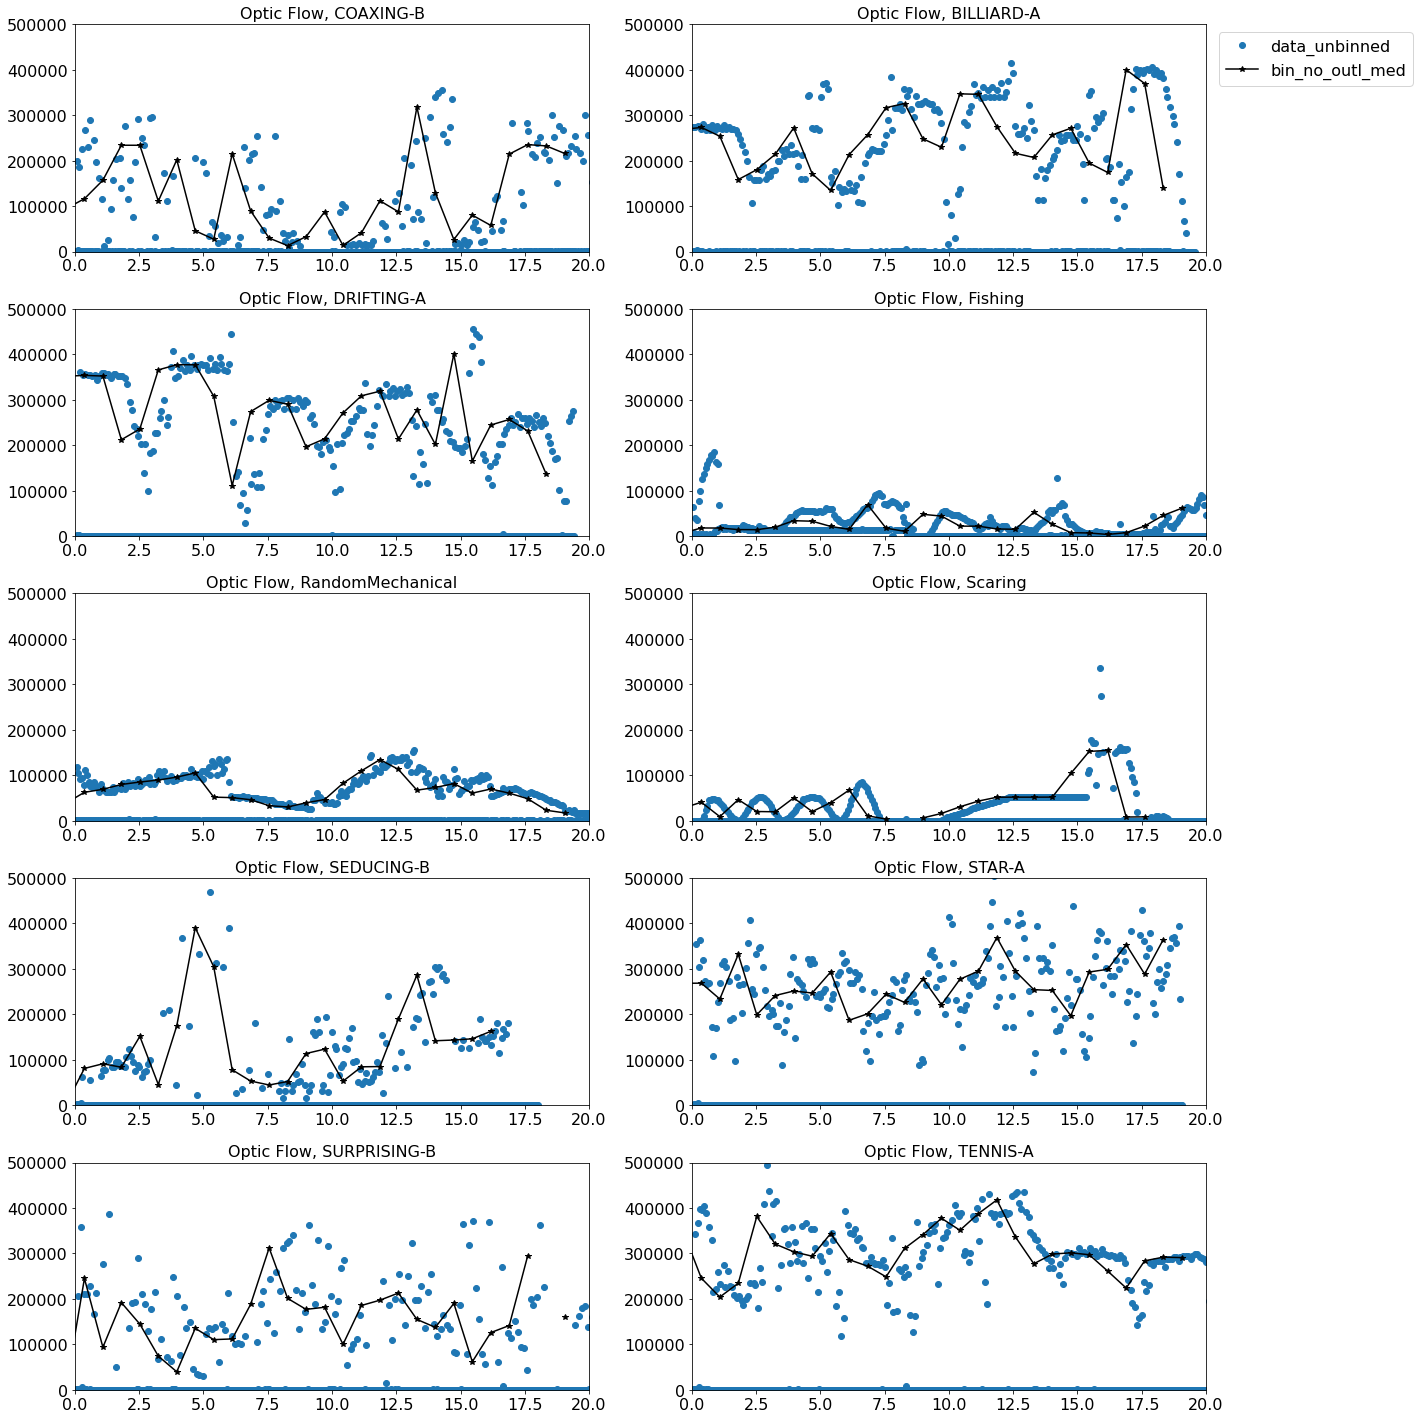

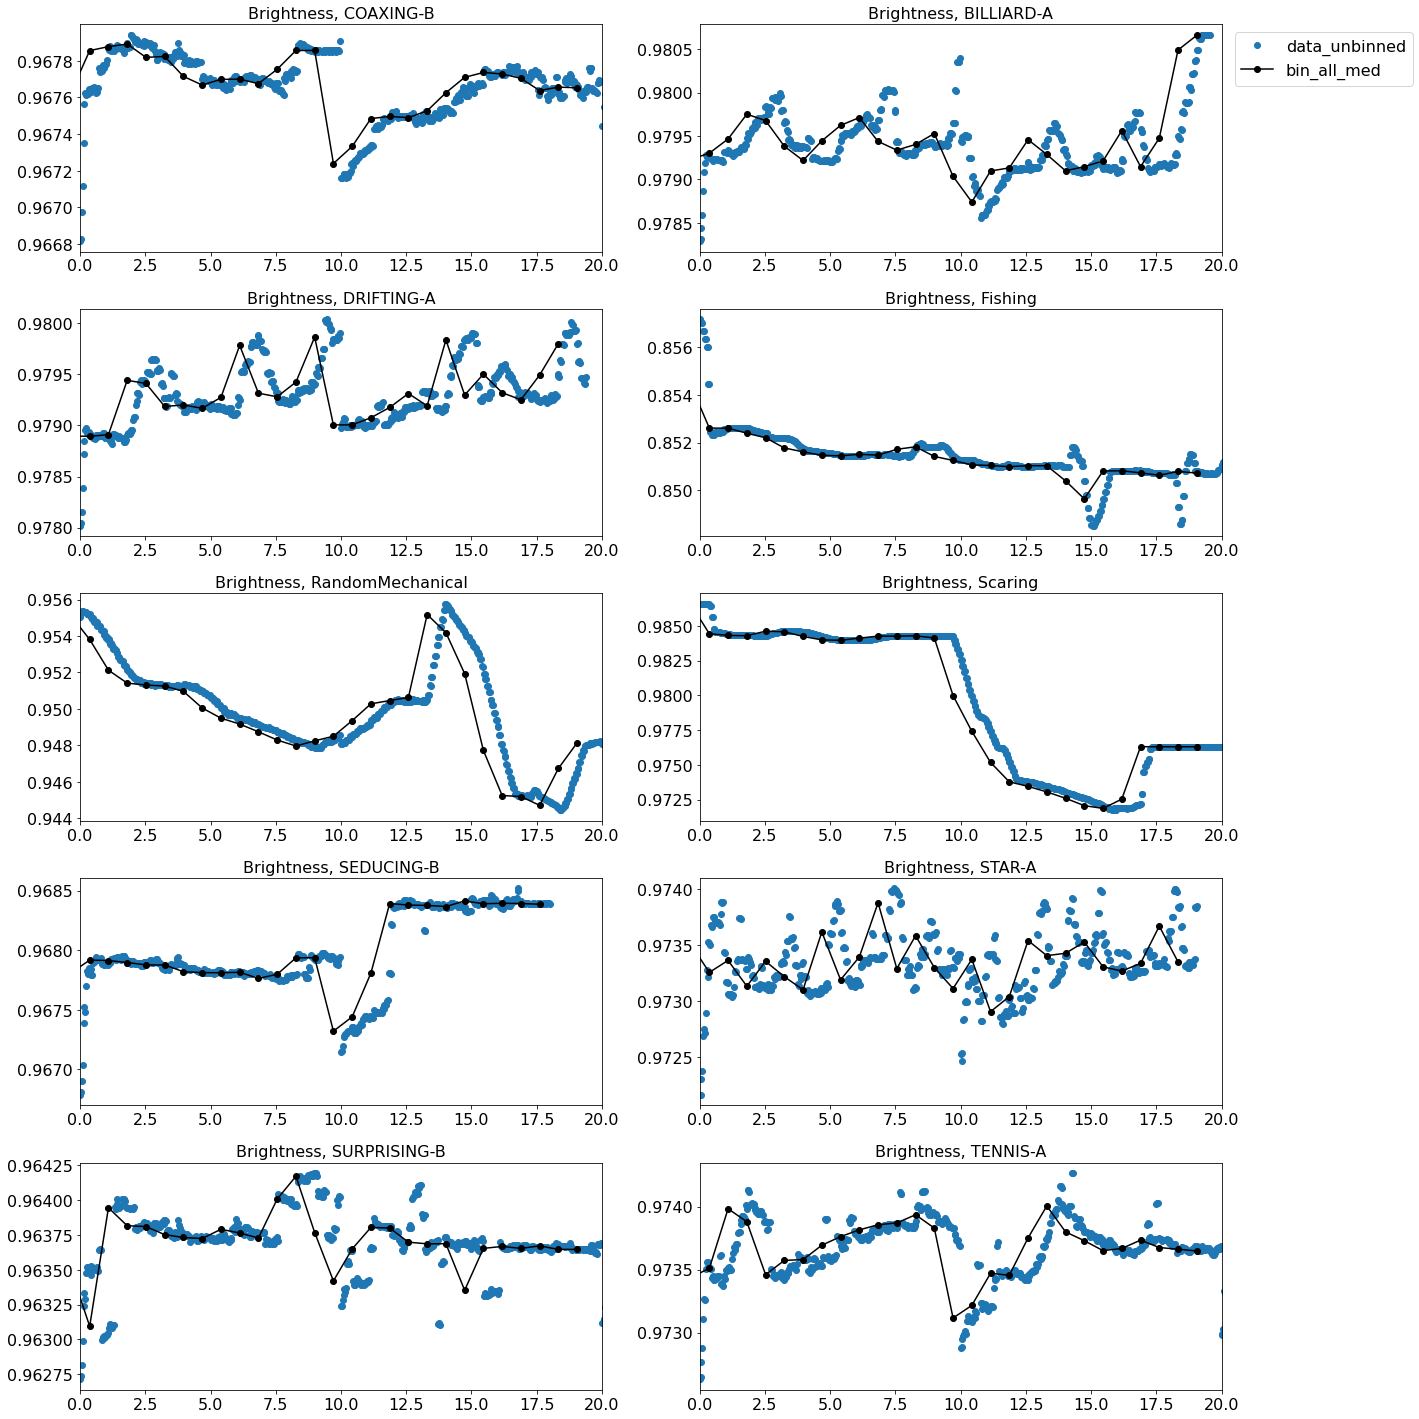

In [48]:
# binning data
TR=.72
of_binned,of_binned_nonan,of_binned_nonan_median,brig_binned,brig_binned_med = [np.empty((28,10)) for _ in range(5)]
of_binned[:],of_binned_nonan[:],of_binned_nonan_median[:],brig_binned[:],brig_binned_med[:] = [np.nan]*5
of_all = []
brig_all = []
of_binned_nonan_sem,brig_binned_sem = [np.empty((28,10)) for _ in range(2)]
of_binned_nonan_sem[:],brig_binned_sem[:] = [np.nan]*2

#optic_flow_tc = []
#brightness_tc = []
for i,vid_name in enumerate(vidnames):
    #vid_name = 'COAXING-B'
    optflow_dat = pd.read_csv('/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/social_stimuli/SOCIAL Stimuli/mp4/hcp10/csv/OptflowExtractor_' + vid_name + '.csv')
    brightness_dat = pd.read_csv('/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/social_stimuli/SOCIAL Stimuli/mp4/hcp10/csv/BrightnessExtractor_' + vid_name + '.csv')
    optflow_dat['onsetTR'] = optflow_dat['onset']/.72
    brightness_dat['onsetTR'] = brightness_dat['onset']/.72

    optflow_dat_nonan = pd.read_csv('/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/social_stimuli/SOCIAL Stimuli/mp4/hcp10/csv/OptflowExtractor_' + vid_name + '.csv')
    optflow_dat_nonan.loc[optflow_dat_nonan['total_flow']<1000,:] = np.nan # remove total optic flow values that are too low
    optflow_dat_nonan = optflow_dat_nonan.loc[~np.isnan(optflow_dat_nonan['total_flow']),]
    optflow_dat_nonan['onsetTR'] = optflow_dat_nonan['onset']/.72
    #optflow_dat['smoothed'] = optflow_dat['total_flow'].rolling(2).median()

    of_all_movie = []
    brig_all_movie = []
    for t in range(28):
        rows = (optflow_dat['onsetTR']>=t) & (optflow_dat['onsetTR']<(t+1)) # rows within a time bin
        of_binned[t,i] = np.mean(optflow_dat.loc[rows,'total_flow']) # data points without removing the low total optic flow values
        
        of_all_movie.append(optflow_dat.loc[rows,'total_flow'].values) # for plotting figures later
        
        #rows = (optflow_dat_nonan['onsetTR']>=(i*TR))&((optflow_dat_nonan['onsetTR']<((i+1)*TR)))
        #print(optflow_dat_nonan.loc[rows,'total_flow'])
        #of_binned[t] = np.mean(optflow_dat_nonan.loc[rows,'total_flow'])
        rows = (optflow_dat_nonan['onsetTR']>=t)&((optflow_dat_nonan['onsetTR']<(t+1))) # rows within a time bin but after excluding low values
        of_binned_nonan[t,i]        = np.nanmean(optflow_dat_nonan.loc[rows,'total_flow']) # computing (for plotting) mean as well as median within a bin  for comparison(next row)
        of_binned_nonan_median[t,i] = np.nanmedian(optflow_dat_nonan.loc[rows,'total_flow']) 
        of_binned_nonan_sem[t,i] = stats.sem(optflow_dat_nonan.loc[rows,'total_flow']) # for a future plot of the binned data as well.

        rows = (brightness_dat['onsetTR']>= t) & (brightness_dat['onsetTR']<(t+1)) # for plotting binned brightness values (same as above, but no low-value issues)
        brig_binned[t,i] = np.nanmean(brightness_dat.loc[rows,'brightness'])
        brig_binned_med[t,i] = np.nanmedian(brightness_dat.loc[rows,'brightness'])
        brig_binned_sem[t,i] =  stats.sem(brightness_dat.loc[rows,'brightness'])
        brig_all_movie.append(brightness_dat.loc[rows,'brightness'].values)
    #plt.plot(of_binned)

    of_all.append(of_all_movie) # for future plots and t-tests between groups/movies
    brig_all.append(brig_all_movie) # for future plots and t-tests between groups/movies

    plt.figure(1,figsize=(20,20))
    plt.subplot(5,2,i+1) # opt flow for each movie
    plt.title(f'Optic Flow, {vid_name}')
    plt.plot(optflow_dat['onset'],optflow_dat['total_flow'],marker = 'o',ls='None',label = 'data_unbinned')
    plt.plot(np.linspace(0,19.4,28)-.35,of_binned_nonan_median[:,i],marker = '*', label = 'bin_no_outl_med',color='k')
    plt.xticks(np.arange(0,21,2.5))
    plt.xlim(0,20)
    plt.ylim(0,500000)
    plt.tight_layout()
    if i == 1:
        plt.legend(bbox_to_anchor=[1.01,1])

    plt.figure(2,figsize=(20,20))
    plt.subplot(5,2,i+1) # brightness for each movie
    plt.title(f'Brightness, {vid_name}')
    plt.plot(brightness_dat['onset'],brightness_dat['brightness'],marker = 'o',ls='None',label='data_unbinned')
    plt.plot(np.linspace(0,19.4,28)-.35,brig_binned_med[:,i],marker = 'o',label='bin_all_med',color='k')
    plt.xticks(np.arange(0,21,2.5))
    plt.xlim(0,20)
    if i == 1:
        plt.legend(bbox_to_anchor=[1.01,1])

    plt.tight_layout()

In [22]:
of_binned_nonan_median.shape

(28, 10)

In [23]:
# pad with NaNs at inds 0,1,2,zscore and save as regressors (not yet pushed by 1 to account for the delay compared to TR0 (which is the TR BEFORE stim onset))
of_reg,brightness_reg,of_reg_z,brightness_reg_z = [np.empty((31,10)) for  _ in range(4)]
of_reg[:],brightness_reg[:],of_reg_z[:],brightness_reg_z[:] = [np.nan]*4

of_reg[tr0_ind:,:] = of_binned_nonan_median
brightness_reg[tr0_ind:,:] = brig_binned_med

for m in range(10):
    of_reg_z[tr0_ind:,m] = stats.zscore(of_reg[tr0_ind:,m],nan_policy='omit')

    brightness_reg_z[tr0_ind:,m] = stats.zscore(brightness_reg[tr0_ind:,m],nan_policy='omit')

np.save('brightness_reg_all_z.npy',brightness_reg_z)
np.save('optic_flow_reg_all_z.npy',of_reg_z)
np.save('brightness_reg_all.npy',brightness_reg)
np.save('optic_flow_reg_all.npy',of_reg)

In [24]:
of_reg_z.shape

(31, 10)

# Plots

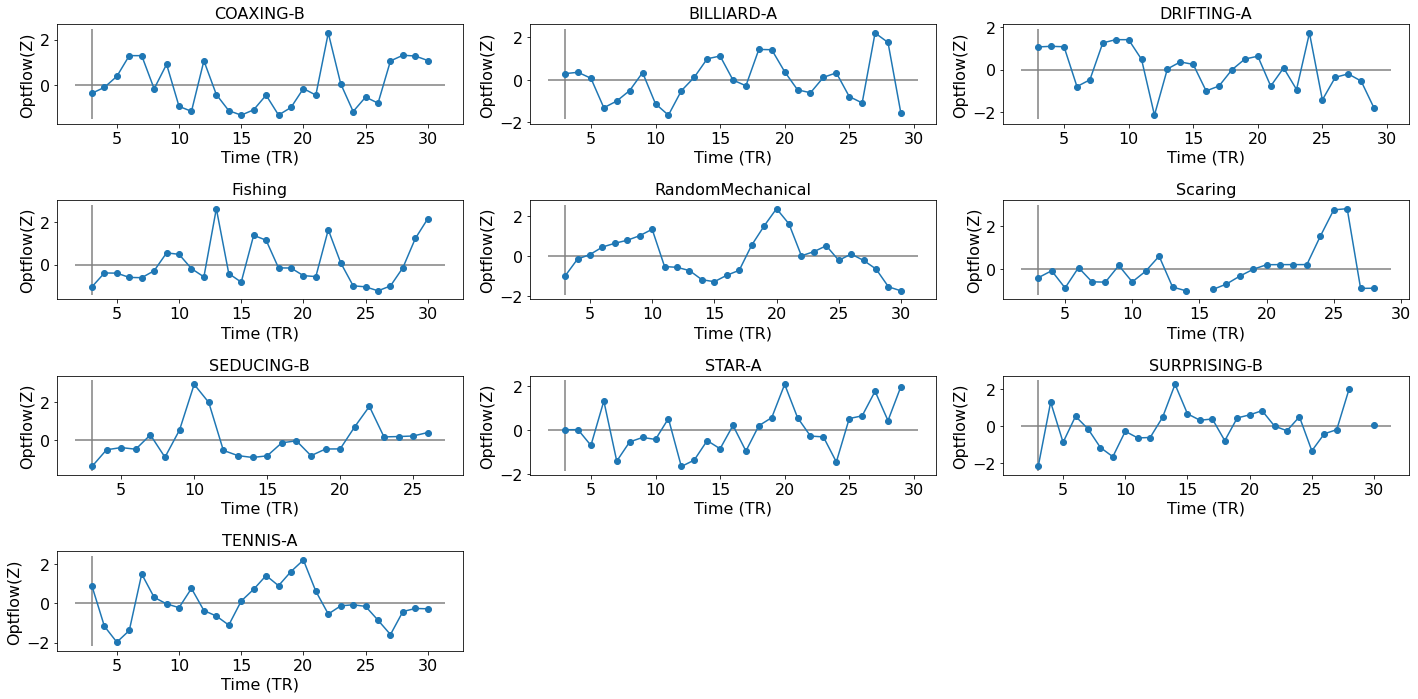

In [33]:
# verifying figures
plt.figure(1,figsize=(20,10))
for m in range(10):
    plt.subplot(4,3,m+1)
    plt.title(vidnames[m])
    plt.plot(of_reg_z[:,m],marker ='o')
    plt.vlines(tr0_ind,plt.ylim()[0],plt.ylim()[1],color='grey')
    plt.hlines(0,plt.xlim()[0],plt.xlim()[1],color='grey')
    plt.xlabel('Time (TR)')
    plt.ylabel('Optflow(Z)')
plt.tight_layout()

In [36]:
of_coax.shape,of_bill.shape

((20,), (4,))

In [40]:
# ttest between coax and bill
of_pval_coaxbill,brig_pval_coaxbill,of_pval_allexcept,brig_pval_allexcept = [np.empty((28,)) for _ in range(4)]
of_pval_coaxbill[:],brig_pval_coaxbill[:], of_pval_allexcept[:],brig_pval_allexcept[:] = [np.nan]*4
movie_ind_1,movie_ind_2 = 0,1 # coax, bill
for t in range(28):
    of_coax,of_bill = of_all[movie_ind_1][t],of_all[movie_ind_2][t] #un-binned data
    brig_coax,brig_bill = brig_all[movie_ind_1][t],brig_all[movie_ind_2][t]
    of_coax[of_coax<1000] = np.nan
    of_bill[of_bill<1000] = np.nan

    if len(of_coax) == len(of_bill): # could be diff if datapts are lost within bin
        _,of_pval_coaxbill[t] = stats.ttest_ind(of_coax,of_bill,nan_policy='omit')
    if len(brig_coax) == len(brig_bill):
        _,brig_pval_coaxbill[t] = stats.ttest_rel(brig_coax,brig_bill,nan_policy='omit')
    else:
        print(t,', not equal')
        
of_pval_coaxbill[of_pval_coaxbill > .05] =  np.nan
brig_pval_coaxbill[brig_pval_coaxbill > .05] =  np.nan

27 , not equal


/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Warning: converting a masked element to nan.
  # This is added back by InteractiveShellApp.init_path()


In [42]:
# ttest between all except coax bill social and nonsocial
of_pval_med,brig_pval_med,of_pval_sem,brig_pval_sem = [np.empty((28,2)) for _ in range(4)]
of_pval_med[:],brig_pval_med[:],of_pval_sem[:],brig_pval_sem[:] = [np.nan]*4
for t in range(28):
    of_ment = []
    of_rand = []
    brig_ment = []
    brig_rand = []
    for m in [3,5,6,8]:
        of_ment.extend(of_all[m][t])
        brig_ment.extend(brig_all[m][t])
    for m in [2,4,7,9]:
        of_rand.extend(of_all[m][t])
        brig_rand.extend(brig_all[m][t])
    of_ment = np.array(of_ment)
    of_rand = np.array(of_rand)
    brig_ment = np.array(brig_ment)
    brig_rand = np.array(brig_rand)
    of_ment[of_ment<1000] = np.nan
    of_rand[of_rand<1000] = np.nan
    of_pval_med[t,0] = np.nanmedian(of_ment)
    of_pval_med[t,1] = np.nanmedian(of_rand)
    of_pval_sem[t,0] = stats.sem(of_ment,nan_policy='omit')
    of_pval_sem[t,1] = stats.sem(of_rand,nan_policy='omit')
    brig_pval_med[t,0] = np.nanmedian(brig_ment)
    brig_pval_med[t,1] = np.nanmedian(brig_rand)
    brig_pval_sem[t,0] = stats.sem(brig_ment,nan_policy='omit')
    brig_pval_sem[t,1] = stats.sem(brig_rand,nan_policy='omit')
    #print(len(of_coax),len(of_bill))
    #if t==2:
    #    print(of_coax,'\n',of_bill)
    _,of_pval_allexcept[t] = stats.ttest_ind(of_ment,of_rand,nan_policy='omit')
    _,brig_pval_allexcept[t] = stats.ttest_ind(brig_ment,brig_rand,nan_policy='omit')

of_pval_allexcept[of_pval_allexcept > .05] =  np.nan
brig_pval_allexcept[brig_pval_allexcept > .05] =  np.nan
        

In [43]:
# get the right red/blue shades
red_rgb =[188,61,62] # from Emily
blue_rgb = [54,122,177] # from Emily
red_rgb = np.array(red_rgb)/255
blue_rgb = np.array(blue_rgb)/255
alpha = .2 # transparency inside boxplots, for datapts etc.

col = [red_rgb, blue_rgb]

In [47]:
of_binned_nonan_median.shape

(28, 10)

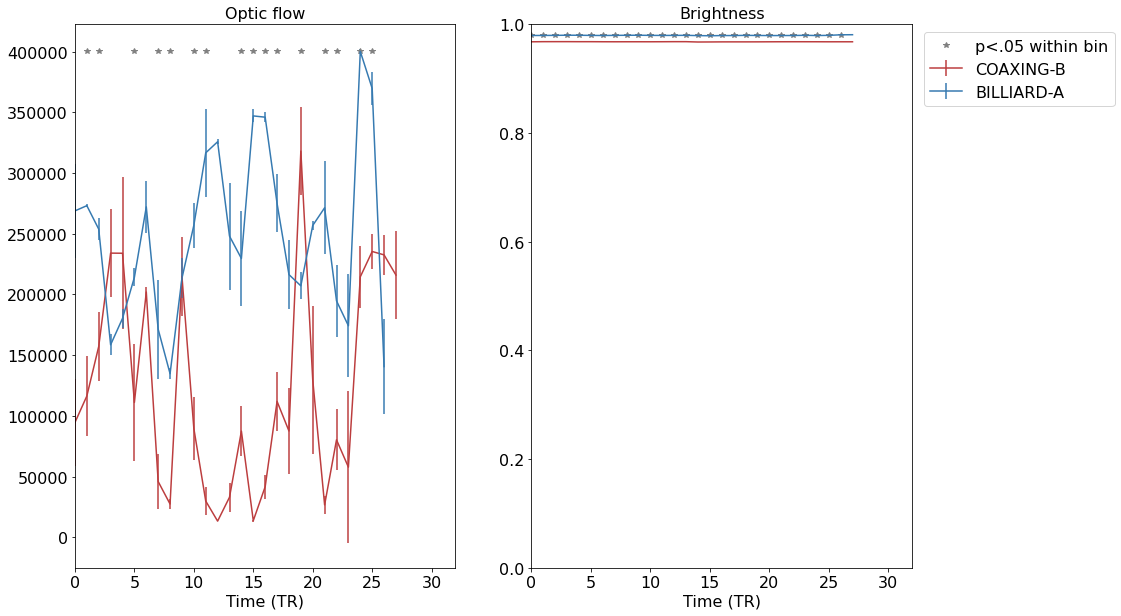

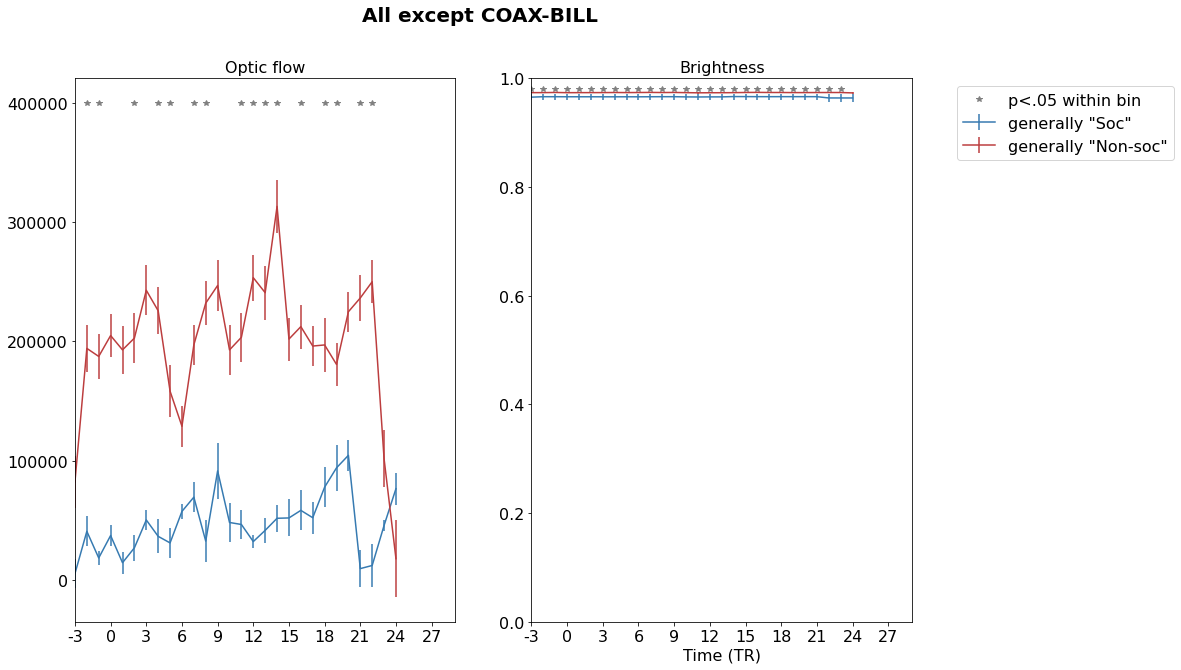

In [63]:
plt.figure(1,figsize=(15,10))
plt.subplot(121)
for m in range(2):
    plt.errorbar(range(28),of_binned_nonan_median[:,m],of_binned_nonan_sem[:,m], color = col[m])
    plt.xlim(0,32)
    plt.xlabel('Time (TR)')    
    
    if m==1:
        points = np.where(~np.isnan(of_pval_coaxbill))[0]
        plt.plot(points,np.repeat(max(of_binned_nonan_median[:,m]), len(points)), marker = '*',ls='None',color='grey', label = 'p<.05 within bin')
        plt.title('Optic flow')
        #plt.legend()

plt.subplot(122)
for m in range(2):
    plt.errorbar(range(28),brig_binned_med[:,m],brig_binned_sem[:,m], color = col[m], label = vidnames[m])
    plt.xlim(0,32)
    xticks = np.arange(0,32,3)
    plt.xlabel('Time (TR)')    
    
    if m==1:
        points = np.where(~np.isnan(brig_pval_coaxbill))[0]
        plt.plot(points,np.repeat(max(brig_binned_med[:,m]), len(points)), marker = '*',ls='None',color='grey',label = 'p<.05 within bin')
        plt.title('Brightness')
        plt.legend(bbox_to_anchor=[1.01,1])
        plt.ylim(0,1)


plt.figure(2,figsize=(15,10))
plt.suptitle('All except COAX-BILL', fontsize=20, fontweight='bold')
plt.subplot(121)
col_allelse = [blue_rgb,red_rgb]
for m in range(2):
    plt.errorbar(range(28),of_pval_med[:,m],of_pval_sem[:,m], color = col_allelse[m])
    plt.xlim(0,32)
    xticks = np.arange(0,32,3)
    plt.xticks(xticks,[str(i-tr0_ind) for i in xticks])
    if m==1:
        points = np.where(~np.isnan(of_pval_coaxbill))[0]
        plt.plot(points,np.repeat(max(of_binned_nonan_median[:,m]), len(points)), marker = '*',ls='None',color='grey', label = 'p<.05 within bin')
        plt.title('Optic flow')
        
lbl = ['generally "Soc" ', 'generally "Non-soc"']
plt.subplot(122)
for m in range(2):
    plt.errorbar(range(28),brig_pval_med[:,m],brig_pval_sem[:,m], color = col_allelse[m],label = lbl[m])
    plt.xlim(0,32)
    xticks = np.arange(0,32,3)
    plt.xticks(xticks,[str(i-tr0_ind) for i in xticks])
    plt.xlabel('Time (TR)')    
    
    if m==1:
        points = np.where(~np.isnan(brig_pval_coaxbill))[0]
        plt.plot(points,np.repeat(max(brig_binned_med[:,m]), len(points)), marker = '*',ls='None',color='grey',label = 'p<.05 within bin')
        plt.title('Brightness')
        plt.legend(bbox_to_anchor=[1.71,1])
        plt.ylim(0,1)


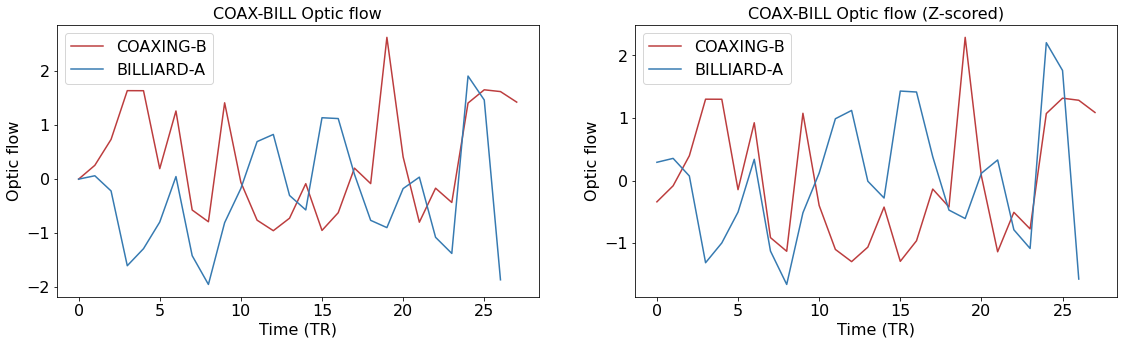

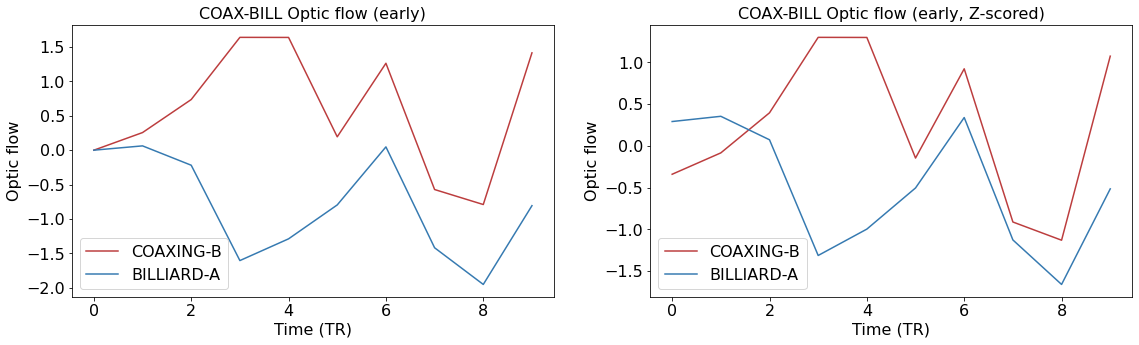

In [28]:
stim_label = np.array([1,0,0,1,0,1,1,0,1,0])

plt.figure(1,figsize=(19,5))
plt.subplot(121)
for m in range(2):
    color = red_rgb if stim_label[m]==1 else blue_rgb
    plt.plot(of_reg[tr0_ind:,m],color=color,label=vidnames[m])
plt.legend()
plt.title('COAX-BILL Optic flow')
plt.ylabel('Optic flow')
plt.xlabel('Time (TR)')

plt.subplot(122)
for m in range(2):
    color = red_rgb if stim_label[m]==1 else blue_rgb
    plt.plot(of_reg_z[tr0_ind:,m],color=color,label=vidnames[m])
plt.legend()
plt.title('COAX-BILL Optic flow (Z-scored)')
plt.ylabel('Optic flow')
plt.xlabel('Time (TR)')


plt.figure(2,figsize=(19,5))
plt.subplot(121)
for m in range(2):
    color = red_rgb if stim_label[m]==1 else blue_rgb
    plt.plot(of_reg[tr0_ind:tr0_ind+10,m],color=color,label=vidnames[m])
plt.title('COAX-BILL Optic flow (early)')
plt.ylabel('Optic flow')
plt.xlabel('Time (TR)')
plt.legend()


plt.subplot(122)
for m in range(2):
    color = red_rgb if stim_label[m]==1 else blue_rgb
    plt.plot(of_reg_z[tr0_ind:tr0_ind+10,m],color=color,label=vidnames[m])
plt.title('COAX-BILL Optic flow (early, Z-scored)')
plt.ylabel('Optic flow')
plt.xlabel('Time (TR)')
plt.legend()

/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice
/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice
/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: Mean of empty slice
/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: Mean of empty slice
/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice


Text(0.5, 0, 'Time (TR)')

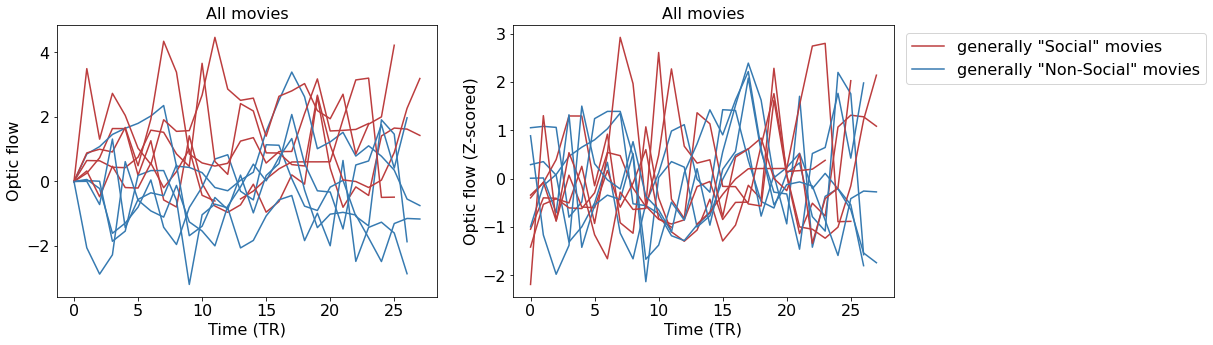

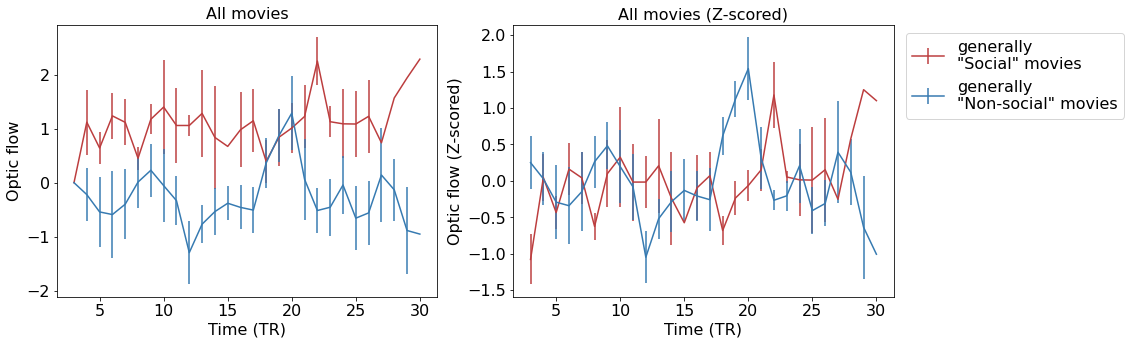

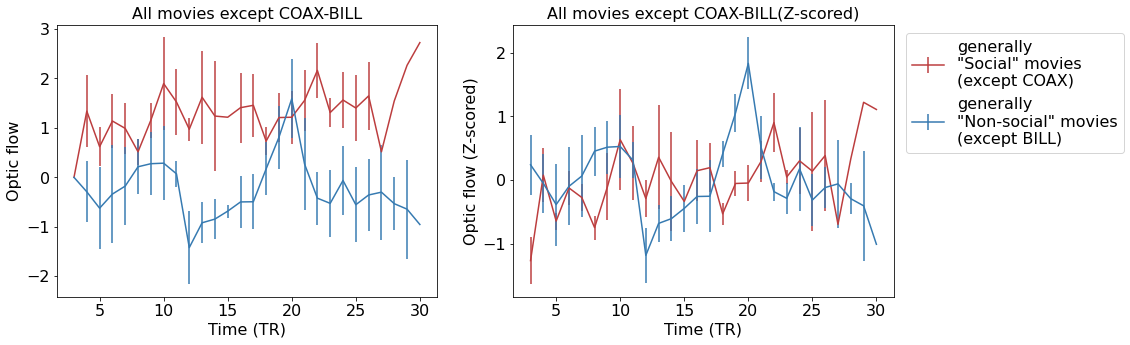

In [29]:
stim_label = np.array([1,0,0,1,0,1,1,0,1,0])
plt.figure(1,figsize=(15,5))
plt.subplot(121)
for m in range(10):
    color = red_rgb if stim_label[m]==1 else blue_rgb
    plt.plot(of_reg[tr0_ind:,m],color=color)
plt.title('All movies')
plt.ylabel('Optic flow')
plt.xlabel('Time (TR)')

plt.subplot(122)
for m in range(10):
    color = red_rgb if stim_label[m]==1 else blue_rgb
    if m == 0:
        plt.plot(of_reg_z[tr0_ind:,m],color=color, label = 'generally "Social" movies')
    elif m == 1:
        plt.plot(of_reg_z[tr0_ind:,m],color=color, label = 'generally "Non-Social" movies')
    else:
        plt.plot(of_reg_z[tr0_ind:,m],color=color)
plt.legend(bbox_to_anchor=[1.01,1])
plt.title('All movies')
plt.ylabel('Optic flow (Z-scored)')
plt.xlabel('Time (TR)')

stim_label = np.array([1,0,0,1,0,1,1,0,1,0])
plt.figure(2,figsize=(15,5))
plt.subplot(121)
plt.errorbar(range(31),np.nanmean(of_reg[:,stim_label==1],axis=1),stats.sem(of_reg[:,stim_label==1],axis=1),color=red_rgb, label = 'generally "Social" movies')
plt.errorbar(range(31),np.nanmean(of_reg[:,stim_label==0],axis=1),stats.sem(of_reg[:,stim_label==0],axis=1),color=blue_rgb, label='generally "Non-social" movies')
plt.title('All movies')
plt.ylabel('Optic flow')
plt.xlabel('Time (TR)')

plt.subplot(122)
plt.errorbar(range(31),np.nanmean(of_reg_z[:,stim_label==1],axis=1),stats.sem(of_reg_z[:,stim_label==1],axis=1),color=red_rgb, label = 'generally\n"Social" movies')
plt.errorbar(range(31),np.nanmean(of_reg_z[:,stim_label==0],axis=1),stats.sem(of_reg_z[:,stim_label==0],axis=1),color=blue_rgb, label='generally\n"Non-social" movies')
plt.legend(bbox_to_anchor =[1.01,1])
plt.title('All movies (Z-scored)')
plt.ylabel('Optic flow (Z-scored)')
plt.xlabel('Time (TR)')

stim_label = np.array([np.nan,np.nan,0,1,0,1,1,0,1,0])
plt.figure(3,figsize=(15,5))
plt.subplot(121)
plt.errorbar(range(31),np.nanmean(of_reg[:,stim_label==1],axis=1),stats.sem(of_reg[:,stim_label==1],axis=1),color=red_rgb, label = 'generally "Social" movies')
plt.errorbar(range(31),np.nanmean(of_reg[:,stim_label==0],axis=1),stats.sem(of_reg[:,stim_label==0],axis=1),color=blue_rgb, label='generally "Non-social" movies')
plt.title('All movies except COAX-BILL')
plt.ylabel('Optic flow')
plt.xlabel('Time (TR)')

plt.subplot(122)
plt.errorbar(range(31),np.nanmean(of_reg_z[:,stim_label==1],axis=1),stats.sem(of_reg_z[:,stim_label==1],axis=1),color=red_rgb, label = 'generally\n"Social" movies\n(except COAX)')
plt.errorbar(range(31),np.nanmean(of_reg_z[:,stim_label==0],axis=1),stats.sem(of_reg_z[:,stim_label==0],axis=1),color=blue_rgb, label='generally\n"Non-social" movies\n(except BILL)')
plt.legend(bbox_to_anchor =[1.01,1])
plt.title('All movies except COAX-BILL(Z-scored)')
plt.ylabel('Optic flow (Z-scored)')
plt.xlabel('Time (TR)')


Ttest_indResult(statistic=array([nan, nan, nan, nan]), pvalue=array([nan, nan, nan, nan]))

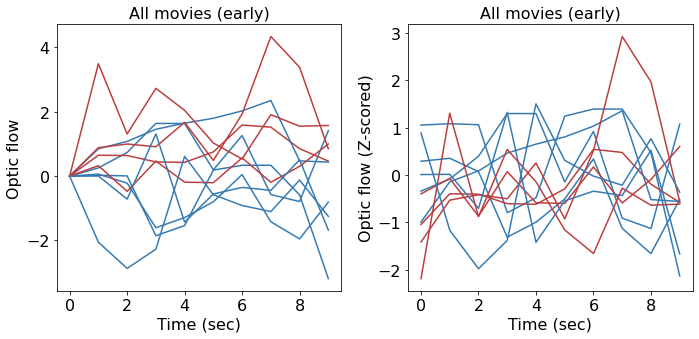

In [32]:
plt.figure(1,figsize=(10,5))
plt.subplot(121)
for m in range(10):
    color = red_rgb if stim_label[m]==1 else blue_rgb
    plt.plot(of_reg[tr0_ind:tr0_ind+10,m],color=color)
plt.title('All movies (early)')
plt.ylabel('Optic flow')
plt.xlabel('Time (sec)')

plt.subplot(122)
for m in range(10):
    color = red_rgb if stim_label[m]==1 else blue_rgb
    plt.plot(of_reg_z[tr0_ind:tr0_ind+10,m],color=color)
plt.title('All movies (early)')
plt.ylabel('Optic flow (Z-scored)')
plt.xlabel('Time (sec)')
plt.tight_layout()

stats.ttest_ind(of_reg[:,stim_label==1],of_reg[:,stim_label==0])